### Resource

- [google drive](https://drive.google.com/drive/u/1/folders/1N15PTA1y0ou5YyPDUN-MdlTGPXq3Rxhc)
- [iowa liquor dataset](https://console.cloud.google.com/bigquery?authuser=1&invt=AbtrQg&project=solid-dominion-452916-p4&supportedpurview=project&ws=!1m5!1m4!4m3!1sbigquery-public-data!2siowa_liquor_sales!3ssales)
- [iowa population](https://data.iowa.gov/Community-Demographics/County-Population-in-Iowa-by-Year/qtnr-zsrc/about_data)
- [iowa income](https://data.iowa.gov/Economic-Statistics/Annual-Personal-Income-for-State-of-Iowa-by-County/st2k-2ti2/about_data)

### Packages

In [1]:
import pandas_gbq
from google.oauth2 import service_account
import pandas as pd
import plotnine as p9
from sodapy import Socrata

# 1. Load Data

## 1-1. Liquor Stores

In [2]:
SERVICE_ACCOUNT_FILE = 'secret/service_account_key.json'
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE)

sql = """
SELECT 
    date,
    store_name,
    city,
    county,
    item_description,
    state_bottle_cost,
    state_bottle_retail,
    bottles_sold,
    sale_dollars,
    volume_sold_liters
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date >= '2024-01-01' AND date < '2025-01-01'
"""

df = pandas_gbq.read_gbq(sql, credentials=credentials)

Downloading: 100%|██████████|


In [41]:
df['gross_profit'] = (
    (df['state_bottle_retail'] - df['state_bottle_cost']) * df['bottles_sold']
)
df.rename(columns={
    'store_name': 'store',
    'item_description': 'item',
}, inplace=True)
df.columns = df.columns.str.lower()
df['store'] = df['store'].str.lower()
df['city'] = df['city'].str.lower()
df['county'] = df['county'].str.lower()
df['item'] = df['item'].str.lower()
df.head()

,date,store,city,county,item,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,profit,gross_profit
0,2024-05-06,riverside #4 / bettendorf,bettendorf,scott,parrot bay variety pack mini,4.80,7.20,1,7.20,0.05,2.4,2.4
1,2024-11-03,tequila's liquor store,des moines,polk,new amsterdam pink whitney bucket mini,55.98,83.97,1,83.97,0.05,27.99,27.99
2,2024-10-23,hy-vee food store / cherokee,cherokee,cherokee,99 toasted flavorites mini,52.32,78.48,1,78.48,0.05,26.16,26.16
3,2024-07-01,fareway stores #963 / cedar rapids,cedar rapids,linn,crown royal regal apple mini,5.91,8.87,1,8.87,0.05,2.96,2.96
4,2024-07-06,casey's general store #3035 / atlant,atlantic,cass,crown royal regal apple mini,5.91,8.87,1,8.87,0.05,2.96,2.96


In [45]:
print("The earliest date:", df['date'].min())
print("The latest date:", df['date'].max())
print("# of stores:", df['store'].nunique())
print("# of cities:", df['city'].nunique())
print("# of counties:", df['county'].nunique())

The earliest date: 2024-01-01
The latest date: 2024-12-31
# of stores: 2151
# of cities: 471
# of counties: 99


In [46]:
df_store = df.groupby(['store', 'city', 'county', 'date', 'item'])['gross_profit'].sum().reset_index(name='gross_plofit')
df_store.head()

,store,city,county,date,item,gross_plofit
0,'da booze barn / west bend,west bend,palo alto,2024-01-04,99 fruits mini,25.8
1,'da booze barn / west bend,west bend,palo alto,2024-01-04,barton vodka,21.18
2,'da booze barn / west bend,west bend,palo alto,2024-01-04,cabo wabo blanco,63.0
3,'da booze barn / west bend,west bend,palo alto,2024-01-04,canadian ltd whisky,30.0
4,'da booze barn / west bend,west bend,palo alto,2024-01-04,captain morgan original spiced mini,2.4


## 1-2. Population

In [61]:
df_pop_city = pd.read_csv('https://mydata.iowa.gov/resource/26ad-icvy.csv')
df_pop_city.columns = df_pop_city.columns.str.lower()
df_pop_city.rename(columns={
    'name': 'city',
    'value': 'pop_city',
    'data_collection_period': 'year'
}, inplace=True)
df_pop_city['city'] = df_pop_city['city'].str[:-6]
df_pop_city['city'] = df_pop_city['city'].str.lower()
df_pop_city['year'] = df_pop_city['year'].str[-4:]
df_pop_city = df_pop_city[['city', 'year', 'pop_city']]
df_pop_city = df_pop_city[df_pop_city['year']=='2022']
df_pop_city['pop_city'] = df_pop_city['pop_city'].astype(int)
df_pop_city

,city,year,pop_city
0,ackley,2022,1699
1,ackworth,2022,106
2,adair,2022,828
3,adel,2022,6090
4,afton,2022,1105
...,...,...,...
936,yale,2022,316
937,yetter,2022,16
938,yorktown,2022,35
939,zearing,2022,655


In [63]:
df_pop_county = pd.read_csv('data/iowa_population_county.csv')
df_pop_county.columns = df_pop_county.columns.str.lower()
df_pop_county.rename(columns={
    'population': 'pop_county'
}, inplace=True)
df_pop_county['year'] = df_pop_county['year'].str[-4:]
df_pop_county['county'] = df_pop_county['county'].str[:-7]
df_pop_county['county'] = df_pop_county['county'].str.lower()
df_pop_county = df_pop_county[['county', 'year', 'pop_county']]
df_pop_county = df_pop_county[df_pop_county['year']=='2023']
df_pop_county

,county,year,pop_county
35,poweshiek,2023,18453
134,jefferson,2023,15440
158,chickasaw,2023,11658
242,mitchell,2023,10518
245,wright,2023,12656
...,...,...,...
3191,webster,2023,36485
3255,plymouth,2023,25722
3288,fayette,2023,19210
3328,jasper,2023,37919


## 1-3. Income

In [55]:
client = Socrata("data.iowa.gov", None)
df_list = []
offset = 0

while True:
    results = client.get("st2k-2ti2",
                         limit = 1000,
                         offset = offset)
    offset = offset + 1000
    df_list.extend(results)

    if len(results) < 1000:
        break

df_income = pd.DataFrame.from_records(df_list)

df_income['date'] = df_income['date'].str[:4]
df_income = df_income[
    (df_income['date']=='2022') & 
    (df_income['variable']=='Per capita personal income')
    ]
df_income.rename(columns={
    'name': 'county',
    'date': 'year',
    'value': 'annual_income',
}, inplace=True)
df_income['county'] = df_income['county'].str.lower()
df_income = df_income[['county', 'year', 'annual_income']]
df_income['annual_income'] = pd.to_numeric(df_income['annual_income'], errors='coerce')
df_income

,county,year,annual_income
51,adair,2022,67668
103,adams,2022,67657
155,allamakee,2022,55015
207,appanoose,2022,47779
259,audubon,2022,69105
...,...,...,...
4939,winnebago,2022,55013
4991,winneshiek,2022,61042
5043,woodbury,2022,51029
5095,worth,2022,55418


## 1-4. Data Frame

In [65]:
df_county = pd.merge(df_pop_county, df_income, on='county', how='left')
df_county = df_county[['county', 'pop_county', 'annual_income']]
df_county

,county,pop_county,annual_income
0,poweshiek,18453,56228
1,jefferson,15440,54979
2,chickasaw,11658,89185
3,mitchell,10518,96075
4,wright,12656,70420
...,...,...,...
94,webster,36485,53508
95,plymouth,25722,67398
96,fayette,19210,52666
97,jasper,37919,50521


# 2. Exploer Data

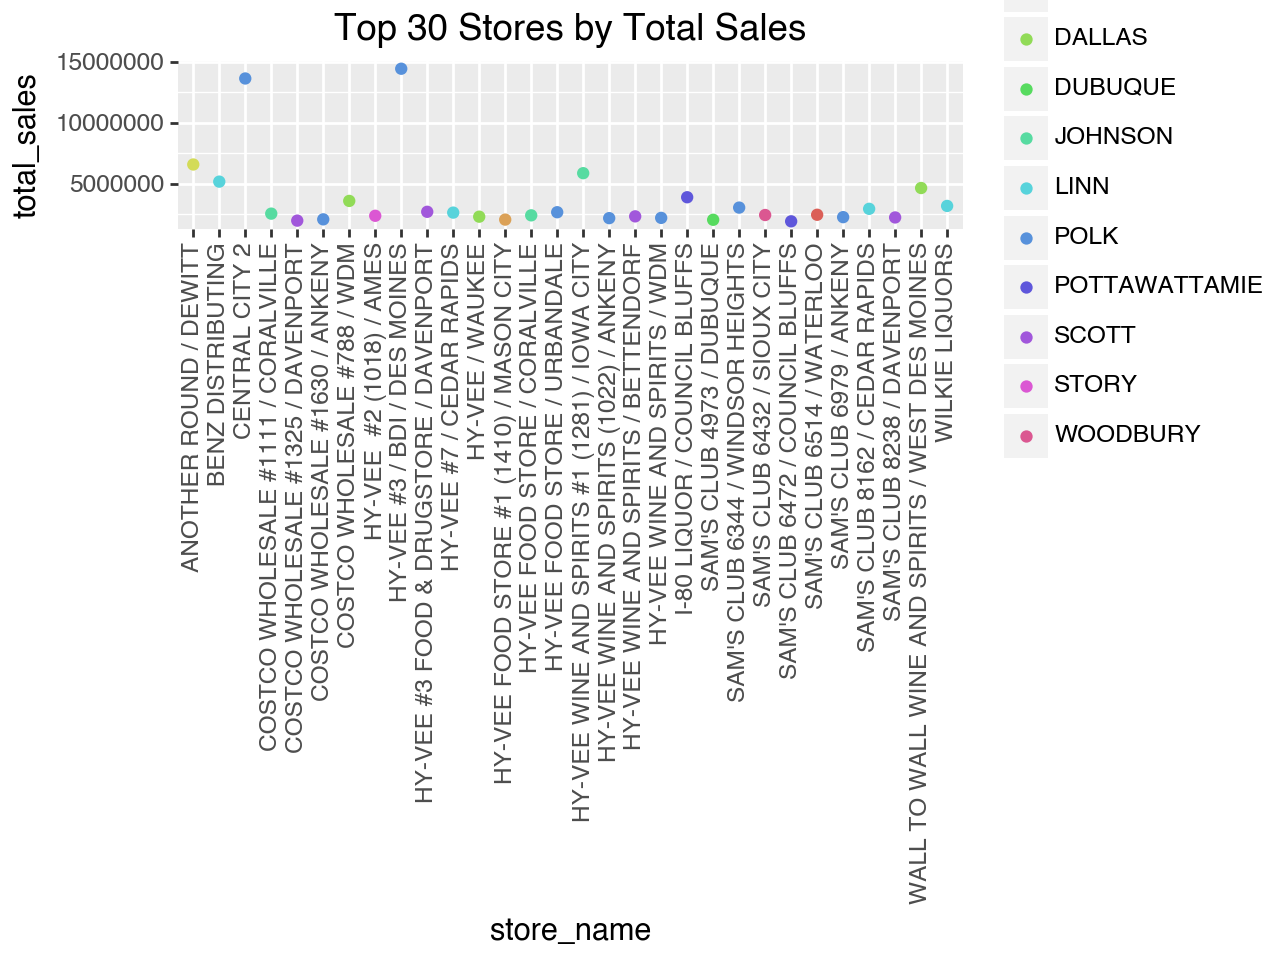

In [9]:
top_stores = df_store.nlargest(30, 'total_sales')
plot = (
    p9.ggplot(top_stores, p9.aes(x='store_name', y='total_sales', color='county')) +
    p9.geom_point() +
    p9.labs(title='Top 30 Stores by Total Sales') +
    p9.theme(axis_text_x=p9.element_text(rotation=90))
)
plot

In [13]:
top_stores['county'].value_counts()

county
POLK             8
LINN             4
SCOTT            4
JOHNSON          3
DALLAS           3
POTTAWATTAMIE    2
CLINTON          1
BLACK HAWK       1
WOODBURY         1
STORY            1
CERRO GORDO      1
DUBUQUE          1
Name: count, dtype: int64

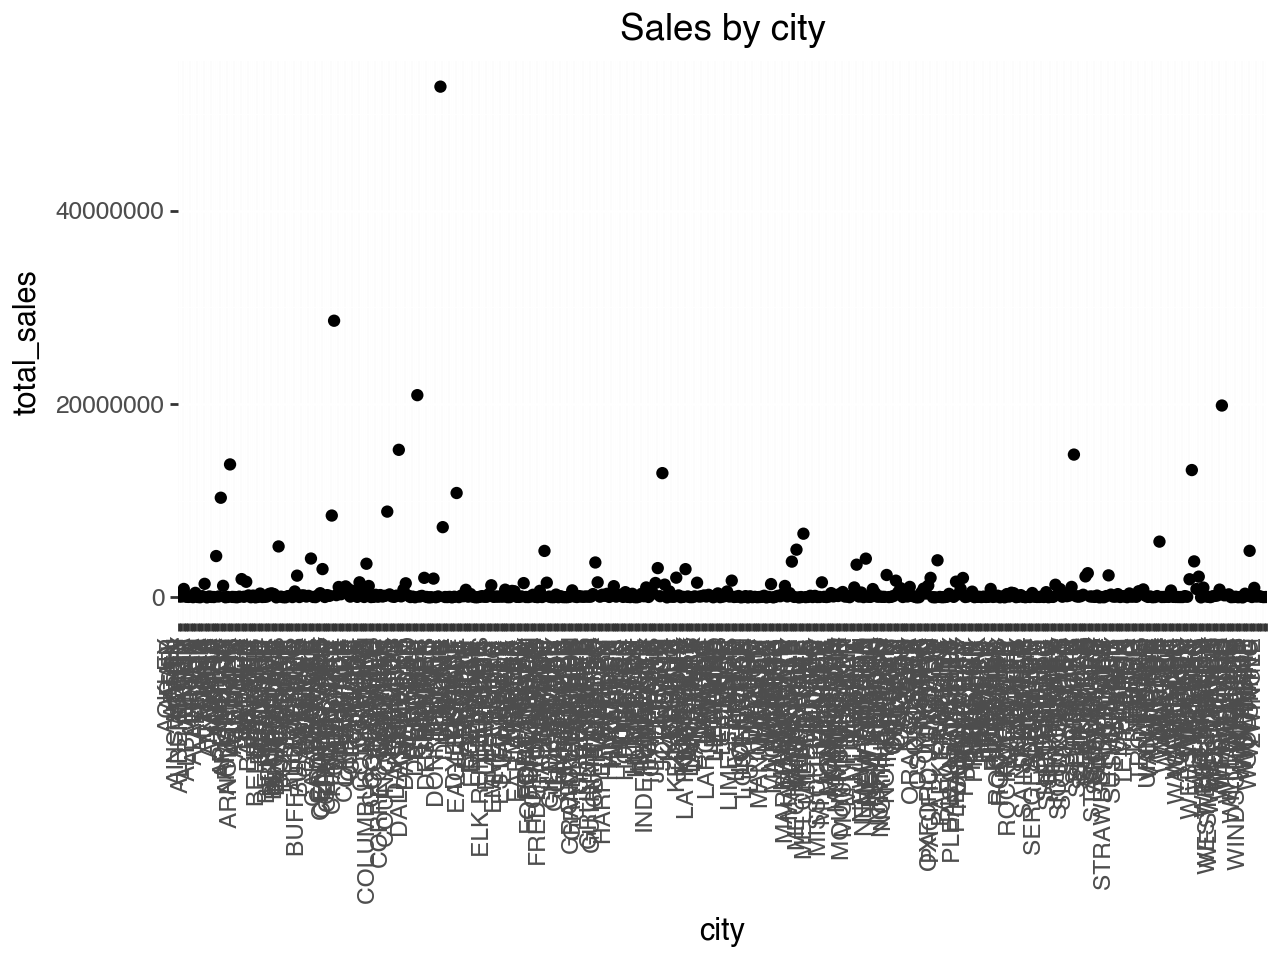

In [30]:
plot2 = (
    p9.ggplot(df_city, p9.aes(x='city', y='total_sales')) +
    p9.geom_point() +
    p9.labs(title='Sales by city') +
    p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1))
)
plot2

In [29]:
df_county = df.groupby(['county']).agg(
    revenue=('sale_dollars', 'sum'),
    profit=('profit', 'sum'),
).reset_index()
df_county['county'] = df_county['county'].str.lower()
df_county.head()

,county,revenue,profit
0,adair,619205.10,206548.04
1,adams,313394.31,104545.9
2,allamakee,1144949.95,382071.19
3,appanoose,1191277.99,397272.15
4,audubon,268753.09,89599.5


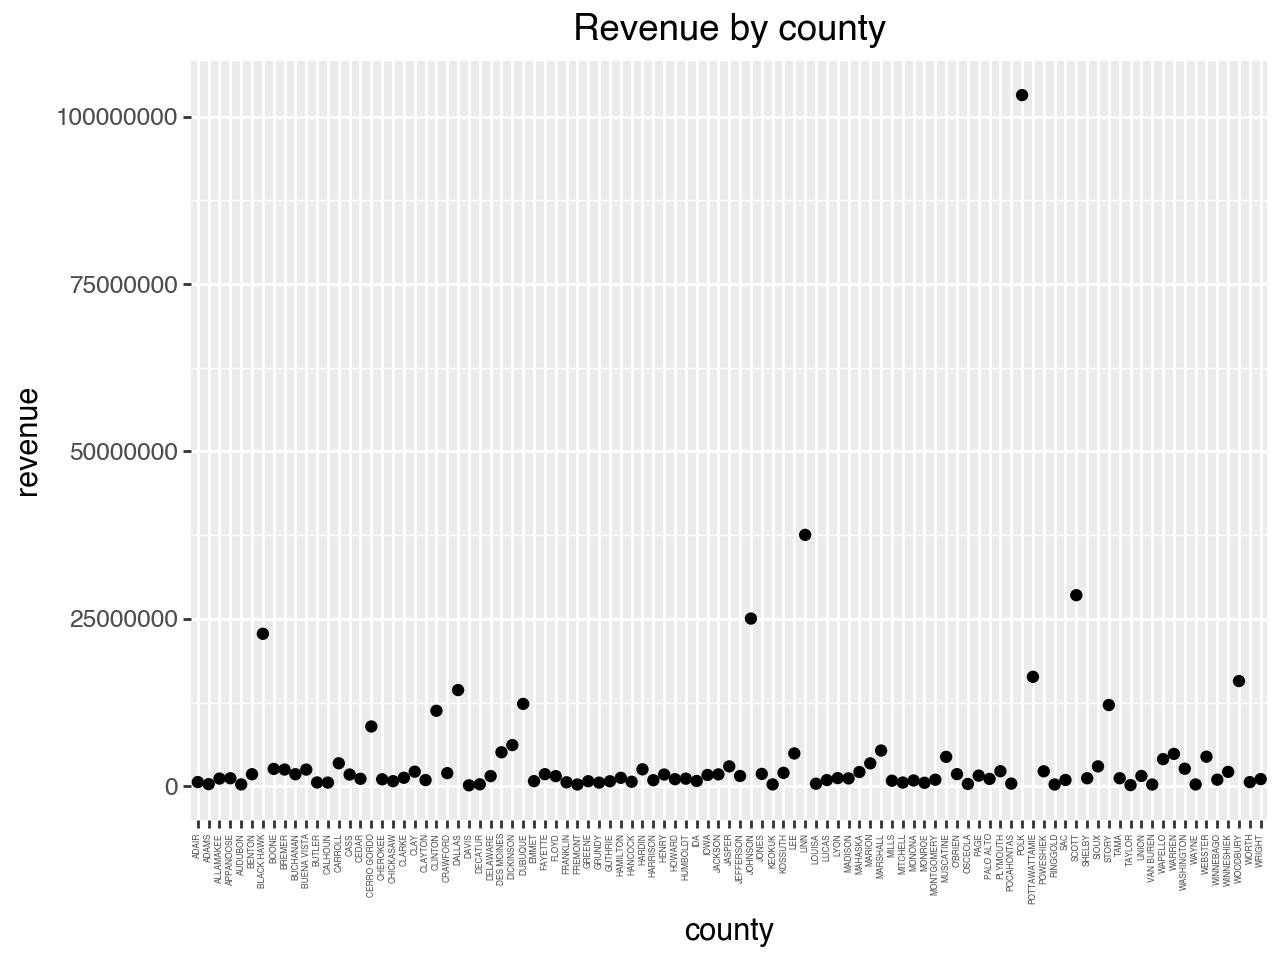

In [15]:
plot3 = (
    p9.ggplot(df_county, p9.aes(x='county', y='revenue')) +
    p9.geom_point() +
    p9.labs(title='Revenue by county') +
    p9.theme(axis_text_x=p9.element_text(rotation=90, size=3))
)
plot3

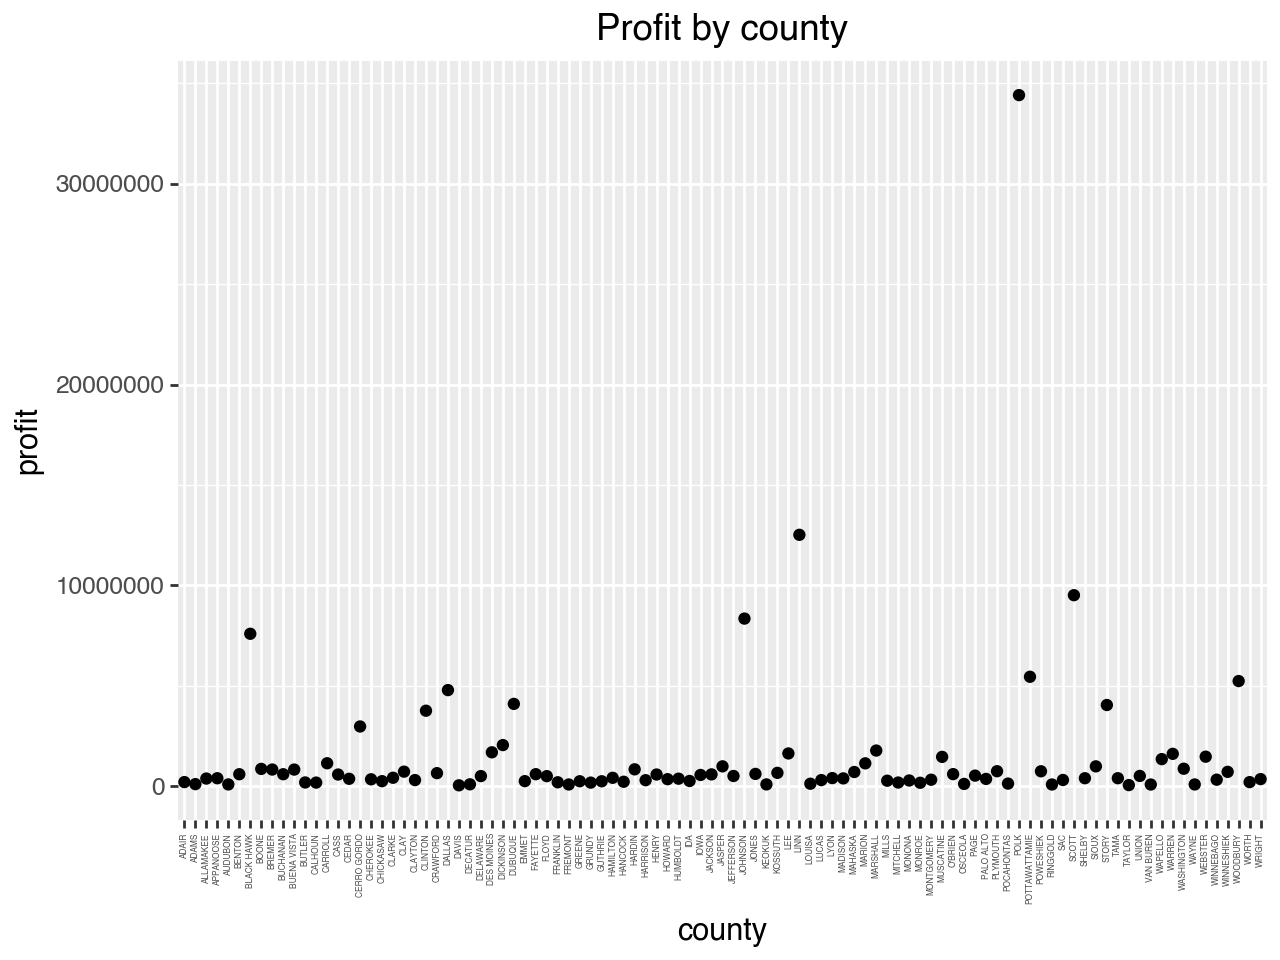

In [16]:
plot4 = (
    p9.ggplot(df_county, p9.aes(x='county', y='profit')) +
    p9.geom_point() +
    p9.labs(title='Profit by county') +
    p9.theme(axis_text_x=p9.element_text(rotation=90, size=3))
)
plot4

In [27]:
df_pop_county = pd.read_csv('data/iowa_population_county.csv')
df_pop_county.columns = df_pop_county.columns.str.lower()
df_pop_county['year'] = df_pop_county['year'].str[-4:]
df_pop_county['county'] = df_pop_county['county'].str[:-7]
df_pop_county['county'] = df_pop_county['county'].str.lower()
df_pop_county = df_pop_county[['county', 'year', 'population']]
df_pop_county = df_pop_county[df_pop_county['year']=='2023']
df_pop_county.head()

,county,year,population
35,poweshiek,2023,18453
134,jefferson,2023,15440
158,chickasaw,2023,11658
242,mitchell,2023,10518
245,wright,2023,12656


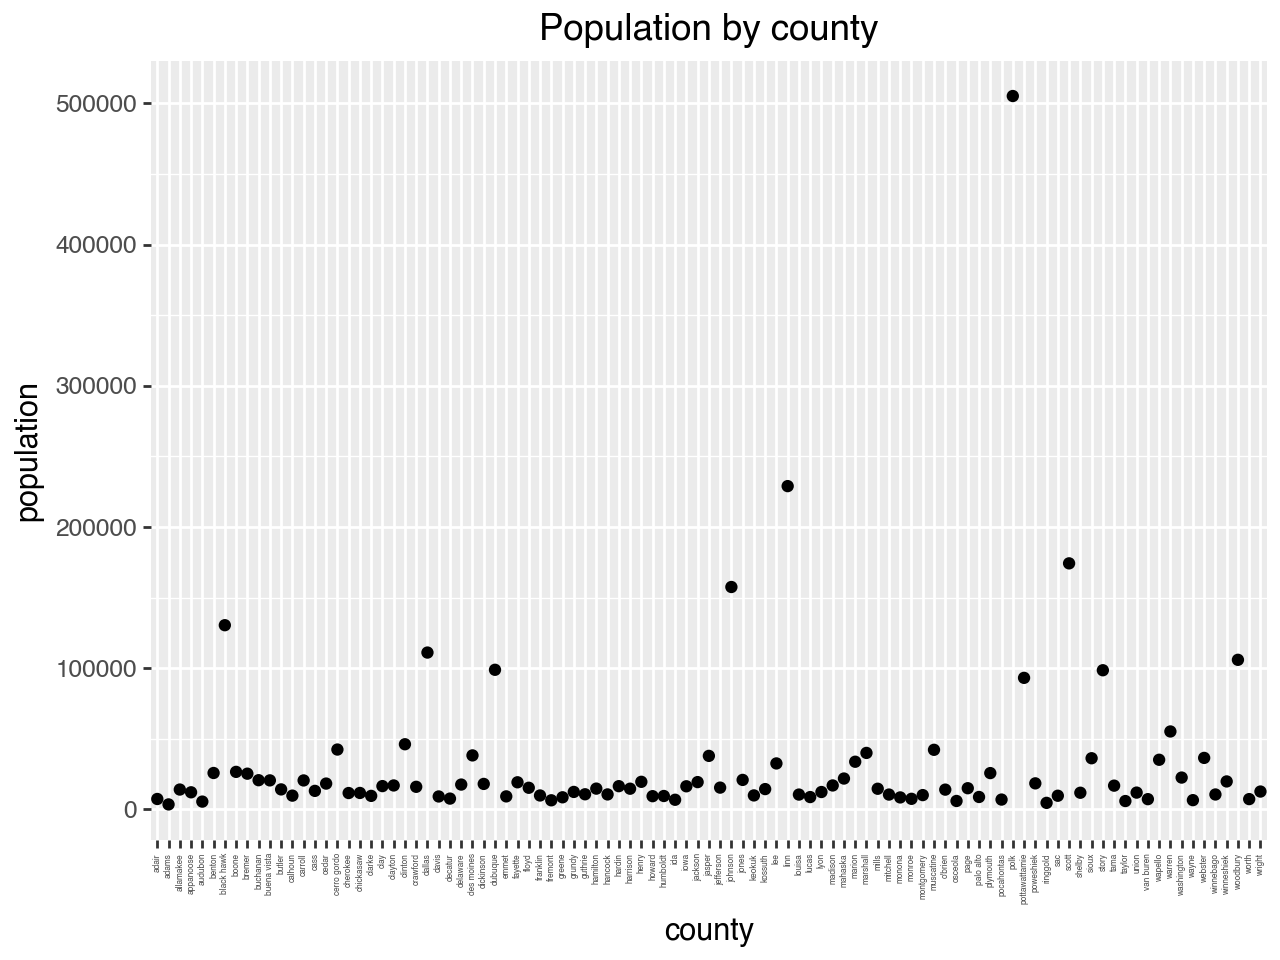

In [39]:
plot5 = (
    p9.ggplot(df_pop_county, p9.aes(x='county', y='population')) +
    p9.geom_point() +
    p9.labs(title='Population by county') +
    p9.theme(axis_text_x=p9.element_text(rotation=90, size=3))
)
plot5

In [37]:
df_pop_city = pd.read_csv('https://mydata.iowa.gov/resource/26ad-icvy.csv')
df_pop_city.columns = df_pop_city.columns.str.lower()
df_pop_city.rename(columns={
    'name': 'city',
    'value': 'population',
    'data_collection_period': 'year'
}, inplace=True)
df_pop_city['city'] = df_pop_city['city'].str[:-6]
df_pop_city['city'] = df_pop_city['city'].str.lower()
df_pop_city['year'] = df_pop_city['year'].str[-4:]
df_pop_city = df_pop_city[['city', 'year', 'population']]
df_pop_city = df_pop_city[df_pop_city['year']=='2022']
df_pop_city

,city,year,population
0,ackley,2022,1699.0
1,ackworth,2022,106.0
2,adair,2022,828.0
3,adel,2022,6090.0
4,afton,2022,1105.0
...,...,...,...
936,yale,2022,316.0
937,yetter,2022,16.0
938,yorktown,2022,35.0
939,zearing,2022,655.0


In [25]:
plot4.save('profit_by_county.png', dpi=300, width=10, height=5)
plot5.save('population_by_county.png', dpi=300, width=10, height=5)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 5 in image.
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: profit_by_county.png
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 5 in image.
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: population_by_county.png


In [20]:
df_pop_profit = pd.merge(df_pop, df_county, on='county', how='inner')
df_pop_profit.head()

NameError: name 'df_county' is not defined

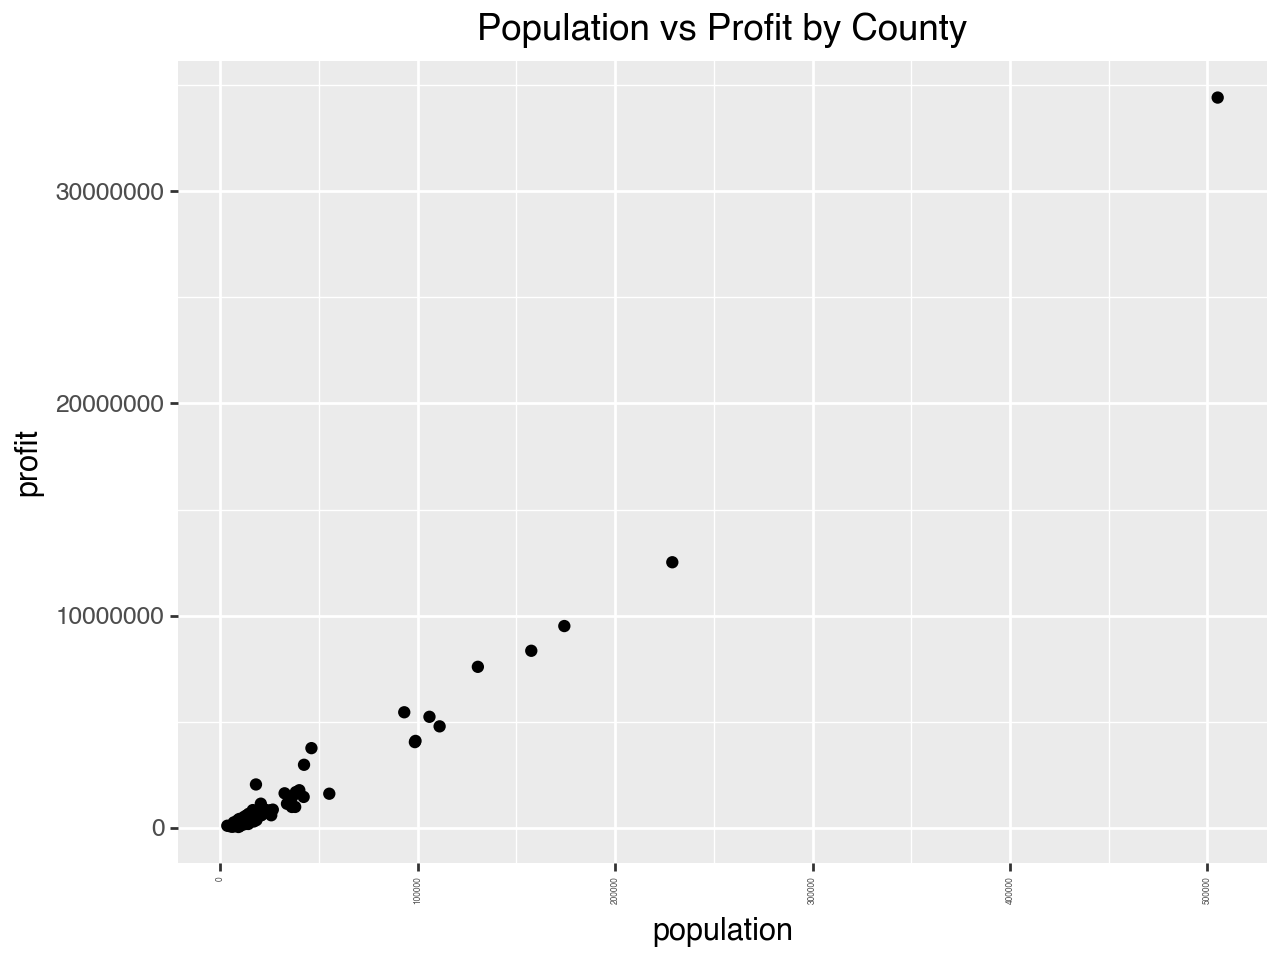

In [33]:
plot6 = (
    p9.ggplot(df_pop_profit, p9.aes(x='population', y='profit')) +
    p9.geom_point() +
    p9.labs(title='Population vs Profit by County') +
    p9.theme(axis_text_x=p9.element_text(rotation=90, size=3))
)
plot6

,row_id,geography_id,name,variable_code,variable,value,variable_unit,date,location,:@computed_region_hhz5_dst4,:@computed_region_y683_txed
0,19001_1997_CAINC1-1_annual,19001,Adair,CAINC1-1,Personal income,176229,Thousands of dollars,1997-12-31T00:00:00.000,"{'type': 'Point', 'coordinates': [-94.478164, ...",4,72
1,19001_1997_CAINC1-3_annual,19001,Adair,CAINC1-3,Per capita personal income,21207,Dollars,1997-12-31T00:00:00.000,"{'type': 'Point', 'coordinates': [-94.478164, ...",4,72
2,19001_1998_CAINC1-1_annual,19001,Adair,CAINC1-1,Personal income,183755,Thousands of dollars,1998-12-31T00:00:00.000,"{'type': 'Point', 'coordinates': [-94.478164, ...",4,72
3,19001_1998_CAINC1-3_annual,19001,Adair,CAINC1-3,Per capita personal income,22126,Dollars,1998-12-31T00:00:00.000,"{'type': 'Point', 'coordinates': [-94.478164, ...",4,72
4,19001_1999_CAINC1-1_annual,19001,Adair,CAINC1-1,Personal income,188850,Thousands of dollars,1999-12-31T00:00:00.000,"{'type': 'Point', 'coordinates': [-94.478164, ...",4,72


In [79]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5148 entries, 0 to 5147
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   row_id                       5148 non-null   object
 1   geography_id                 5148 non-null   object
 2   name                         5148 non-null   object
 3   variable_code                5148 non-null   object
 4   variable                     5148 non-null   object
 5   value                        5148 non-null   object
 6   variable_unit                5148 non-null   object
 7   date                         5148 non-null   object
 8   location                     5148 non-null   object
 9   :@computed_region_hhz5_dst4  5148 non-null   object
 10  :@computed_region_y683_txed  5148 non-null   object
dtypes: object(11)
memory usage: 442.5+ KB


,county,year,annual_income
51,adair,2022,67668
103,adams,2022,67657
155,allamakee,2022,55015
207,appanoose,2022,47779
259,audubon,2022,69105


In [81]:
df_income.shape[0]

99

In [71]:
df_income['county'].nunique()

99

In [17]:
df_pop_profit_income = pd.merge(df_pop_profit, df_income, on='county', how='inner')
df_pop_profit_income.head()

NameError: name 'df_pop_profit' is not defined

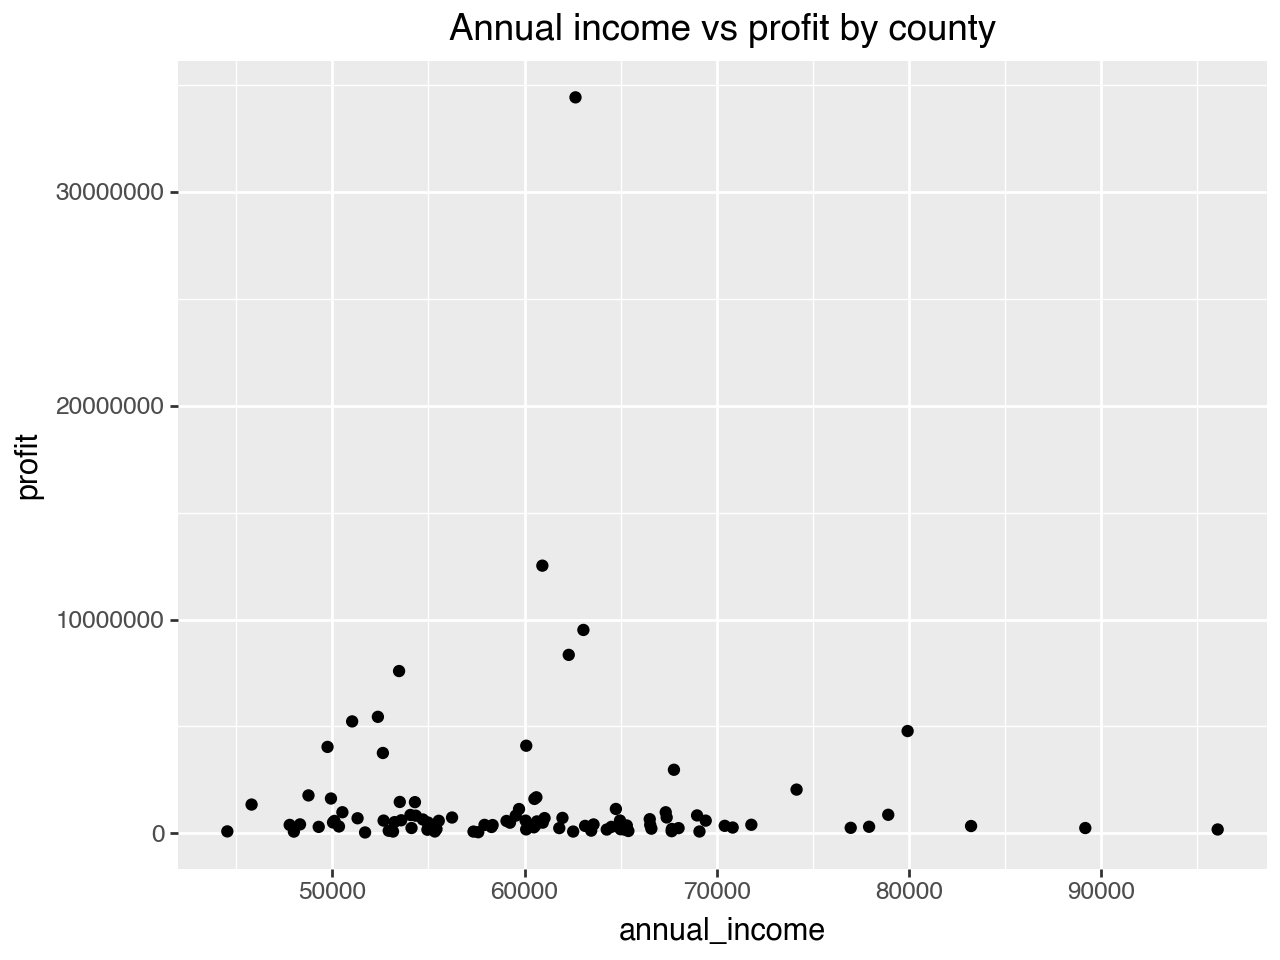

In [85]:
plot7 = (
    p9.ggplot(df_pop_profit_income) +
    p9.aes(x='annual_income', y='profit') +
    p9.geom_point() +
    p9.labs(title='Annual income vs profit by county')
)
plot7

In [87]:
df_pop_profit_income[df_pop_profit_income['profit'] > 10000000]

,county,year_x,population,revenue,profit,year_y,annual_income
49,polk,2023,505255,1.032223e+08,34411573.16,2022,62653
92,linn,2023,228972,3.753996e+07,12518203.1,2022,60928


In [14]:
top_population = df_pop_profit_income.nlargest(30, 'population')
top_population.head()

NameError: name 'df_pop_profit_income' is not defined

,name,data_collection_period,value,change_rate
0,"Ackley, Iowa",2018-2022,1699.0,-0.017351
1,"Ackworth, Iowa",2018-2022,106.0,-0.511521
2,"Adair, Iowa",2018-2022,828.0,-0.031579
3,"Adel, Iowa",2018-2022,6090.0,0.484280
4,"Afton, Iowa",2018-2022,1105.0,0.240180
...,...,...,...,...
995,"Baldwin, Iowa",2017-2021,111.0,-0.239726
996,"Balltown, Iowa",2017-2021,49.0,-0.279412
997,"Bancroft, Iowa",2017-2021,673.0,-0.054775
998,"Bankston, Iowa",2017-2021,2.0,-0.928571
